# Using Python for neuroimaging data - Nilearn

The primary goal of this section is to become familiar with loading, modifying, saving, and visualizing neuroimages in Python. A secondary goal is to develop a conceptual understanding of the data structures involved, to facilitate diagnosing problems in data or analysis pipelines.

To these ends, we'll be exploring two libraries: [nibabel](http://nipy.org/nibabel/) and [nilearn](https://nilearn.github.io/). Each of these projects has excellent documentation. While this should get you started, it is well worth your time to look through these sites.

This notebook only covers nilearn, see the notebook [`image_manipulation_nibabel.ipynb`](image_manipulation_nibabel.ipynb) for more information about nibabel.

# Nilearn

[Nilearn](http://nilearn.github.io/index.html) labels itself as: *A Python module for fast and easy statistical learning on NeuroImaging data. It leverages the scikit-learn Python toolbox for multivariate statistics with applications such as predictive modeling, classification, decoding, or connectivity analysis.*

But it's much more than that. It is also an excellent library to **manipulate** (e.g. resample images, smooth images, ROI extraction, etc.) and **visualize** your neuroimages.

So let's visit all three of those domains:

1. Image manipulation
2. Image visualization

## Setup

In [1]:
# Image settings
from nilearn import plotting
import pylab as plt
%matplotlib inline

import numpy as np

Throughout this tutorial, we will be using the anatomical and functional image of subject 1. So let's load them already here that we have a quicker access later on:

In [2]:
from nilearn import image as nli
t1 = nli.load_img('/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz')
bold = nli.load_img('/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz')

Because the bold image didn't reach steady-state at the beginning of the image, let's cut of the first 5 volumes, to be sure:

In [3]:
bold = bold.slicer[..., 5:]

## 1. Image manipulation with `nilearn`

### Let's create a mean image

If you use nibabel to compute the mean image, you first need to load the img, get the data and then compute the mean thereof. With nilearn, you can do all this in just one line with `mean image`.

In [4]:
img = nli.mean_img(bold)

From version `0.5.0` on, `nilearn` provides interactive visual views. A nice alternative to `nibabel`'s `orthoview()`:


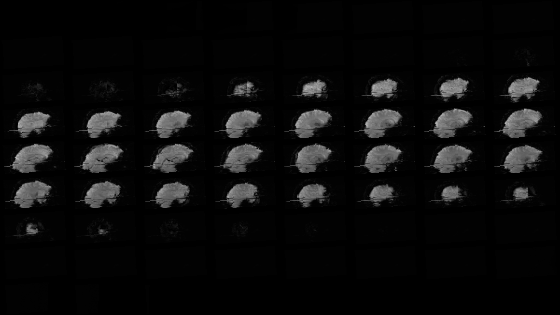
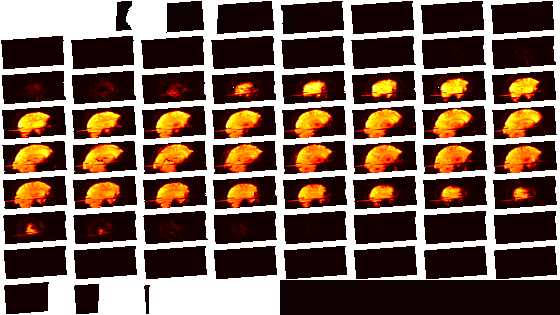

In [5]:
plotting.view_img(img, bg_img=img)

Perfect! What else can we do with the `image` module?  
Let's see...

### Resample image to a template
Using `resample_to_img`, we can resample one image to have the same dimensions as another one. For example, let's resample an anatomical T1 image to the computed mean image above.

In [6]:
mean = nli.mean_img(bold)
print([mean.shape, t1.shape])

[(64, 64, 30), (256, 156, 256)]


Let's resample the t1 image to the mean image.

In [7]:
resampled_t1 = nli.resample_to_img(t1, mean)
resampled_t1.shape

(64, 64, 30)

The image size of the resampled t1 image seems to be right. But what does it look like?

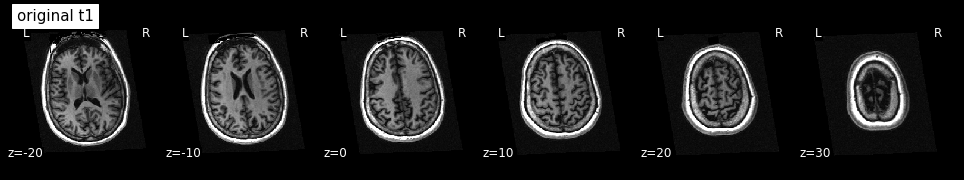

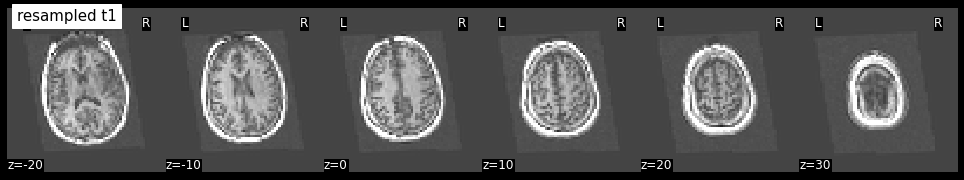

In [8]:
plotting.plot_anat(t1, title='original t1', display_mode='z', dim=-1,
                   cut_coords=[-20, -10, 0, 10, 20, 30])
plotting.plot_anat(resampled_t1, title='resampled t1', display_mode='z', dim=-1,
                   cut_coords=[-20, -10, 0, 10, 20, 30])

### Smooth an image
Using `smooth_img`, we can very quickly smooth any kind of MRI image. Let's, for example, take the mean image from above and smooth it with different FWHM values.

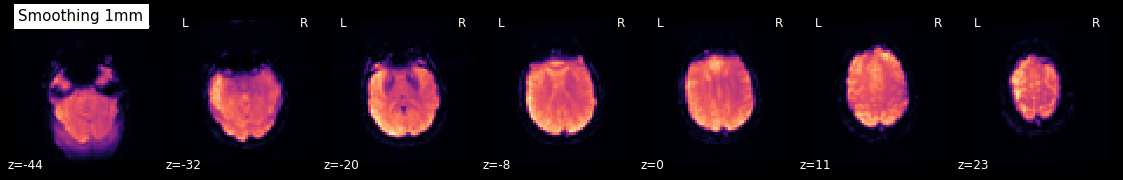

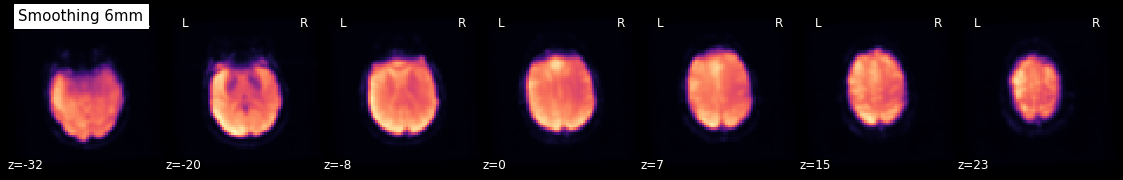

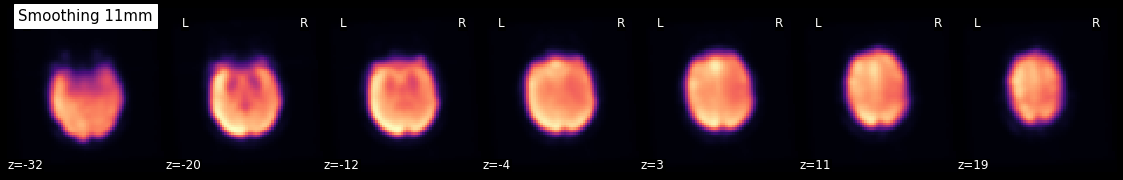

In [9]:
for fwhm in range(1, 12, 5):
    smoothed_img = nli.smooth_img(mean, fwhm)
    plotting.plot_epi(smoothed_img, title="Smoothing %imm" % fwhm,
                     display_mode='z', cmap='magma')

### Clean an image to improve SNR

Sometimes you also want to clean your functional images a bit to improve the SNR. For this, nilearn offers `clean_img`. You can improve the SNR of your fMRI signal by using one or more of the following options:

- detrend
- standardize
- remove confounds
- low- and high-pass filter

**Note:** Low-pass filtering improves specificity. High-pass filtering should be kept small, to keep some sensitivity.

First, let's get the TR value of our functional image:

In [10]:
TR = bold.header['pixdim'][4]
TR

2.5

As a first step, let's just detrend the image.

In [11]:
func_d = nli.clean_img(bold, detrend=True, standardize=False, t_r=TR)

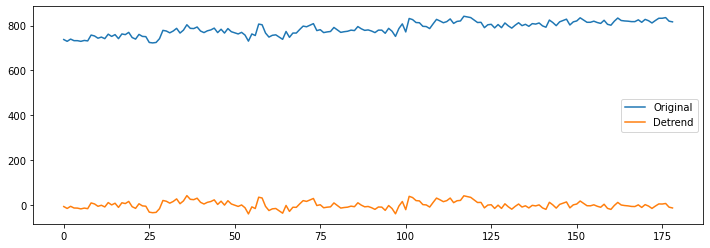

In [12]:
# Plot the original and detrended timecourse of a random voxel
x, y, z = [31, 14, 7]
plt.figure(figsize=(12, 4))
plt.plot(np.transpose(bold.get_fdata()[x, y, z, :]))
plt.plot(np.transpose(func_d.get_fdata()[x, y, z, :]))
plt.legend(['Original', 'Detrend']);

Let's now see what `standardize` does:

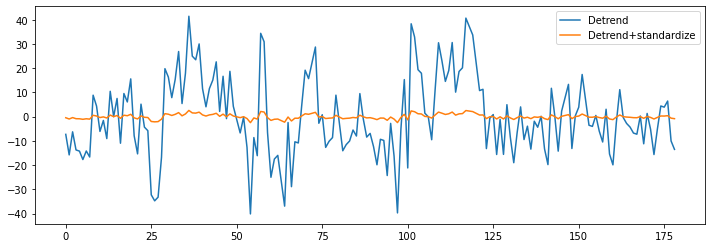

In [13]:
func_ds = nli.clean_img(bold, detrend=True, standardize=True, t_r=TR)

plt.figure(figsize=(12, 4))
plt.plot(np.transpose(func_d.get_fdata()[x, y, z, :]))
plt.plot(np.transpose(func_ds.get_fdata()[x, y, z, :]))
plt.legend(['Detrend', 'Detrend+standardize']);

And as a final step, let's also remove the influence of the motion parameters from the signal.

In [14]:
import pandas as pd
ts_confounds = pd.read_csv('/data/ds000114/derivatives/fmriprep/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold_desc-confounds_timeseries.tsv', sep='\t')[5:][['X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']]

In [15]:
func_ds_c = nli.clean_img(bold, detrend=True, standardize=True, t_r=TR,
                          confounds=ts_confounds)

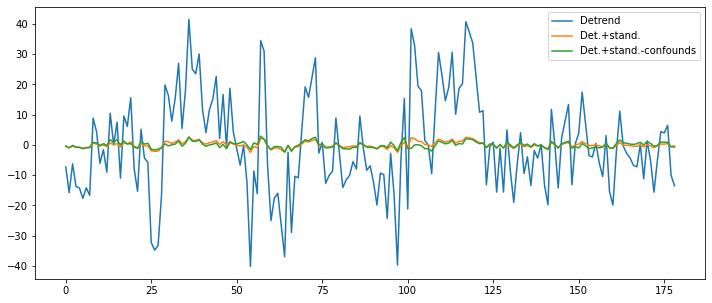

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(np.transpose(func_d.get_fdata()[x, y, z, :]))
plt.plot(np.transpose(func_ds.get_fdata()[x, y, z, :]))
plt.plot(np.transpose(func_ds_c.get_fdata()[x, y, z, :]))
plt.legend(['Detrend', 'Det.+stand.', 'Det.+stand.-confounds']);

### Mask an image and extract an average signal of a region

Thanks to nibabel and nilearn you can consider your images just a special kind of a numpy array. Which means that you have all the liberties that you are used to.

For example, let's take a functional image, (1) create the mean image thereof, then we (2) threshold it to only keep the voxels that have a value that is higher than 95% of all voxels. Of this thresholded image, we only (3) keep those regions that are bigger than 1000mm^3. And finally, we (4) binarize those regions to create a mask image.

So first, we load again a functional image and compute the mean thereof.

In [17]:
mean = nli.mean_img(bold)

Use `threshold_img` to only keep voxels that have a value that is higher than 95% of all voxels.

In [18]:
thr = nli.threshold_img(mean, threshold='95%')


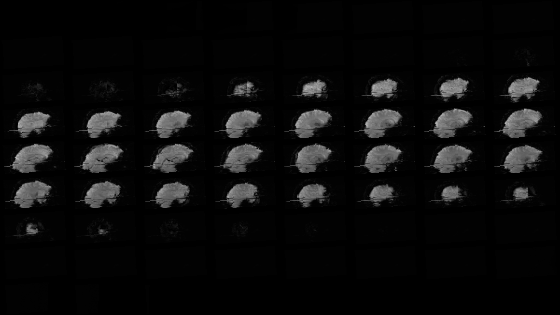
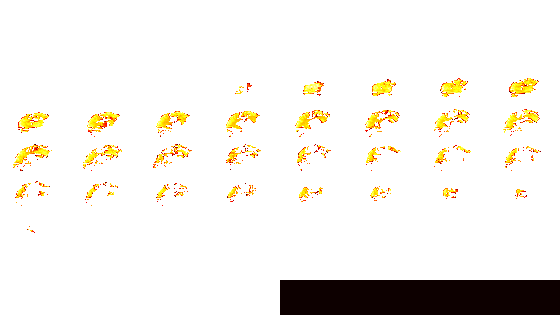

In [19]:
plotting.view_img(thr, bg_img=img)

Now, let's only keep those voxels that are in regions/clusters that are bigger than 1000mm^3.

In [20]:
voxel_size = np.prod(thr.header['pixdim'][1:4])  # Size of 1 voxel in mm^3
voxel_size

63.9996

Let's create the mask that only keeps those big clusters.

In [21]:
from nilearn.regions import connected_regions
cluster = connected_regions(thr, min_region_size=1000. / voxel_size, smoothing_fwhm=1)[0]

And finally, let's `binarize` this cluster file to create a `mask`.

In [22]:
mask = nli.math_img('np.mean(img,axis=3) > 0', img=cluster)

Now let us investigate this mask by visualizing it on the subject specific anatomy:

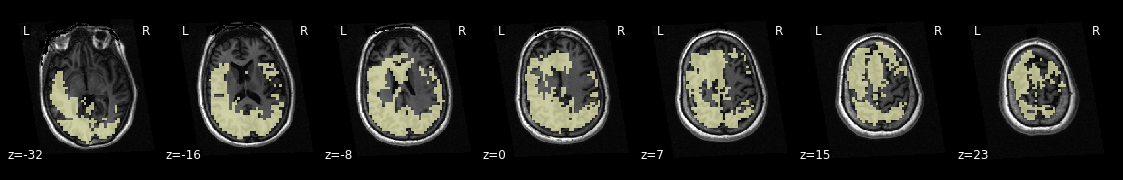

In [23]:
from nilearn.plotting import plot_roi
plotting.plot_roi(mask, bg_img=t1, display_mode='z', dim=-.5, cmap='magma_r');

Next step is now to take this `mask`, apply it to the original `functional image` and `extract` the `mean` of the `temporal signal`.

In [24]:
# Apply mask to original functional image
from nilearn.masking import apply_mask

all_timecourses = apply_mask(bold, mask)
all_timecourses.shape

(179, 5929)

**Note:** You can bring the timecourses (or masked data) back into the original 3D/4D space with `unmask`:

In [25]:
from nilearn.masking import unmask
img_timecourse = unmask(all_timecourses, mask)

Compute mean trace of all extracted timecourses and plot the mean signal.

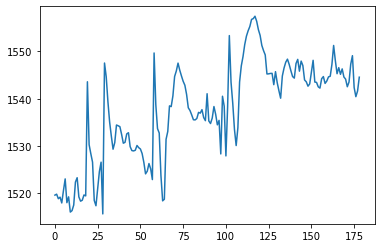

In [26]:
mean_timecourse = all_timecourses.mean(axis=1)
plt.plot(mean_timecourse)

### Extracting signal from `fMRI` volumes

**this part is heavily based on [Elizabeth DuPre's NiLearn tutorial](https://emdupre.github.io/nha2020-nilearn/01-data-structures.html)**

What we just did but didn't really specify/talk about is `extracting signal from fMRI volumes`. In more detail, we want to `extract` and potentially `transform` `data` to a format that we can easily work with. For example, we could work with the full `whole-brain time series` directly via using the [NiftiMasker object](https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMasker.html#nilearn.input_data.NiftiMasker) and specifying the `T1 template` as `mask_img`. But we often want to `reduce the dimensionality` of our data in a structured way. That is, we may only want to consider signal within certain learned or pre-defined `regions of interest (ROIs)`, and when taking into account known sources of noise. To do this, we'll use [nilearn's Masker objects](https://nilearn.github.io/manipulating_images/masker_objects.html). What are the `masker objects` ? First, let's think about what `masking fMRI data` is doing:

<img title="fmri masking" alt="Alt text" src="https://raw.githubusercontent.com/neurohackademy/nh2020-curriculum/master/we-nilearn-dupre/book/_images/masking.jpg">

Essentially, we can imagine overlaying a `3D grid` on an `image`. Then, our `mask` tells us which cubes or `“voxels”` (like `3D pixels`) to sample from. Since our `Nifti images` are `4D files`, we can’t overlay a single grid – instead, we use a series of `3D grids` (one for each `volume` in the `4D file`), so we can get a measurement for each `voxel` at each `timepoint`.

`Masker objects` allow us to apply these `masks`! To start, we need to define a `mask` (or `masks`) that we'd like to apply. This could correspond to one or many `regions of interest`. `Nilearn` provides methods to define your own `functional parcellation` (using `clustering algorithms` such as `k-means`), and it also provides access to other `atlases` that have previously been defined by researchers.

Lets use the [MSDL atlas](https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_atlas_msdl.html#nilearn.datasets.fetch_atlas_msdl), which defines a set of `probabilistic ROIs` across the brain. 

In [27]:
import numpy as np
from nilearn.datasets import fetch_atlas_msdl

msdl_atlas = fetch_atlas_msdl()

msdl_coords = msdl_atlas.region_coords
n_regions = len(msdl_coords)

print(f'MSDL has {n_regions} ROIs, part of the following networks :\n{np.unique(msdl_atlas.networks)}.')


Dataset created in /home/neuro/nilearn_data/msdl_atlas

MSDL has 39 ROIs, part of the following networks :
[b'Ant IPS' b'Aud' b'Basal' b'Cereb' b'Cing-Ins' b'D Att' b'DMN'
 b'Dors PCC' b'L V Att' b'Language' b'Motor' b'Occ post' b'R V Att'
 b'Salience' b'Striate' b'Temporal' b'Vis Sec'].


 ...done. (1 seconds, 0 min)
Extracting data from /home/neuro/nilearn_data/msdl_atlas/5d25e157f36214b8ca9a12fd417aac1c/MSDL_rois.zip..... done.
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/numpy/lib/npyio.py:2372: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


`Nilearn` ships with several `atlases` commonly used in the field, including the `Schaefer atlas` and the `Harvard-Oxford atlas`.

It also provides us with easy ways to view these `atlases` directly. Because `MSDL` is a `probabilistic atlas`, we can view it using:

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)


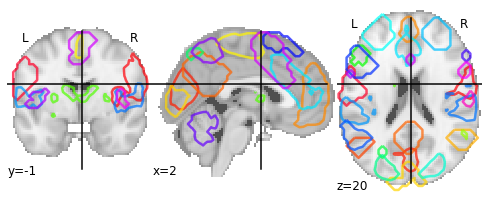

In [28]:
plotting.plot_prob_atlas(msdl_atlas.maps)

#### A quick side-note on the NiftiMasker zoo

We'd like to supply these `ROIs` to a `Masker object`. All `Masker objects` share the same basic structure and functionality, but each is designed to work with a different kind of `ROI`.

The canonical [nilearn.input_data.NiftiMasker](https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMasker.html) works well if we want to apply a `single mask` to the data, like a `single region of interest`.

But what if we actually have several `ROIs` that we'd like to apply to the data all at once? If these `ROIs` are `non-overlapping`, as in "hard" or `deterministic parcellations`, then we can use [nilearn.input_data.NiftiLabelsMasker](https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiLabelsMasker.html). Because we're working with "soft" or `probabilistic ROIs`, we can instead supply these `ROIs` to [nilearn.input_data.NiftiMapsMasker](https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMapsMasker.html).

For a full list of the available Masker objects, see the [Nilearn documentation](https://nilearn.github.io/modules/reference.html#module-nilearn.input_data).

#### Applying a `Masker object``

We can supply our `MSDL atlas-defined ROIs` to the `NiftiMapsMasker object`, along with `resampling`, `filtering`, and `detrending parameters`.

In [29]:
from nilearn import input_data

masker = input_data.NiftiMapsMasker(
    msdl_atlas.maps, resampling_target="data",
    t_r=2, detrend=True,
    low_pass=0.1, high_pass=0.01).fit()

One thing you might notice from the above code is that immediately after defining the `masker object`, we call the `.fit` method on it. This method may look familiar if you've previously worked with `scikit-learn estimators`!

You'll note that we're not supplying any data to this `.fit` method; that's because we're `fitting` the `Masker` to the provided `ROIs`, rather than to our `data`.

We'll then apply it to `transform` our `fMRI volumes`, i.e. `extracting time-course` for each `voxel`. Please note that we will now use the `pre-processed` version of the `fMRI volumes` which were `spatially normalized` to the `template image` we're using as a `mask`. The correct alignment between the `mask` and `fMRI volumes` from which you want to extract data is crucial!

In [30]:
bold_norm = nli.load_img('/data/ds000114/derivatives/fmriprep/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_space-MNI152nlin2009casym_desc-preproc_bold.nii.gz')
bold_norm.get_fdata().shape

(49, 58, 49, 184)

In [31]:
roi_time_series = masker.transform(bold_norm)
roi_time_series.shape

(184, 39)

If you'll remember, when we first looked at the `data` its original `dimensions` were `(49, 58, 49, 184)`. Now, it has a shape of `(184, 39)`. What happened?!

Rather than providing information on every `voxel` within our original `3D grid`, we're now only considering those `voxels` that fall in our `39 regions of interest` provided by the `MSDL atlas` and `aggregating` across `voxels` within those `ROIs`. This reduces each `3D volume` from a dimensionality of `(49, 58, 49)` to just `39`, for our `39` provided `ROIs`.

You'll also see that the `"dimensions flipped"` that is, that we've `transposed the matrix` such that `time` is now the `first` rather than `second dimension`. This follows the `scikit-learn convention` that `rows` in a `data matrix` are `samples`, and `columns` in a `data matrix` are `features`.

<img title="samples" alt="Alt text" src="https://raw.githubusercontent.com/neurohackademy/nh2020-curriculum/master/we-nilearn-dupre/book/_images/samples-features.png">

### Independent Component Analysis

Nilearn gives you also the possibility to run an ICA on your data. This can either be on a single file or on multiple subjects.

In [32]:
# Import CanICA module
from nilearn.decomposition import CanICA

# Specify relevant parameters
n_components = 5
fwhm = 6.

In [33]:
# Specify CanICA object
canica = CanICA(n_components=n_components, smoothing_fwhm=fwhm,
                memory="nilearn_cache", memory_level=2,
                threshold=3., verbose=10, random_state=0, n_jobs=-1,
                standardize=True)

In [34]:
# Run/fit CanICA on input data
canica.fit(bold)

[MultiNiftiMasker.fit] Loading data from [Nifti1Image(
shape=(64, 64, 30, 179),
affine=array([[-3.99471426e+00, -2.04233140e-01,  2.29353290e-02,
         1.30641693e+02],
       [-2.05448717e-01,  3.98260689e+00, -3.10890853e-01,
        -9
[MultiNiftiMasker.fit] Computing mask


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


[MultiNiftiMasker.transform] Resampling mask
[CanICA] Loading data
________________________________________________________________________________
[Memory] Calling sklearn.utils.extmath.randomized_svd...
randomized_svd(array([[-0.004331, ...,  0.001822],
       ...,
       [ 0.006247, ..., -0.022585]], dtype=float32), n_components=5, transpose=True, random_state=0, n_iter=3)
___________________________________________________randomized_svd - 0.0s, 0.0min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    1.7s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.7s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished


CanICA(detrend=True, do_cca=True, high_pass=None, low_pass=None, mask=None,
    mask_args=None, mask_strategy='epi',
    memory=Memory(location=nilearn_cache/joblib), memory_level=2,
    n_components=5, n_init=10, n_jobs=-1, random_state=0,
    smoothing_fwhm=6.0, standardize=True, t_r=None, target_affine=None,
    target_shape=None, threshold=3.0, verbose=10)

In [35]:
# Retrieve the independent components in brain space
components_img = canica.masker_.inverse_transform(canica.components_)

Let's now visualize those components on the T1 image.

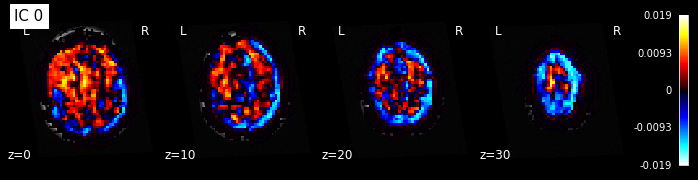

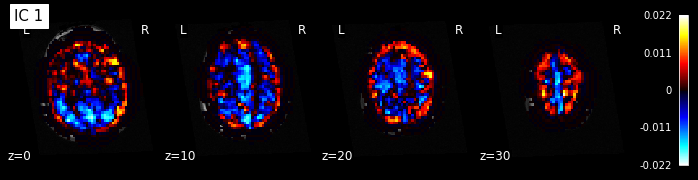

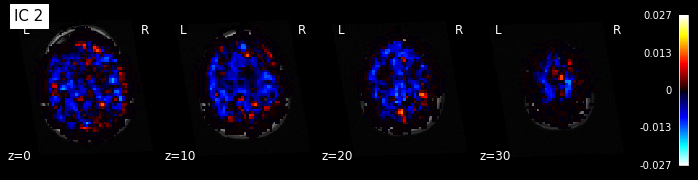

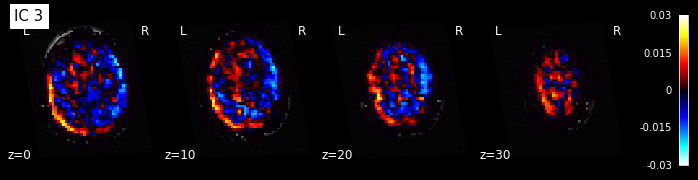

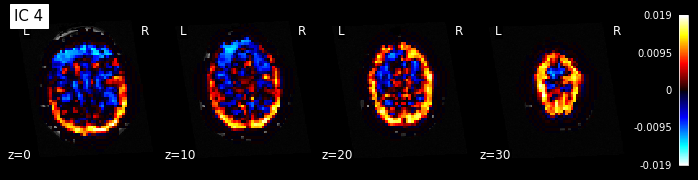

In [36]:
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map

for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="z", title="IC %d" % i,
                  cut_coords=[0, 10, 20, 30], colorbar=True, bg_img=t1)

**Note:** The ICA components are not ordered, the visualization above and below therefore might look different from case to case. 

If you're now also curious about how those independent components, correlate with the functional image over time, you can use the following code to get some insights:

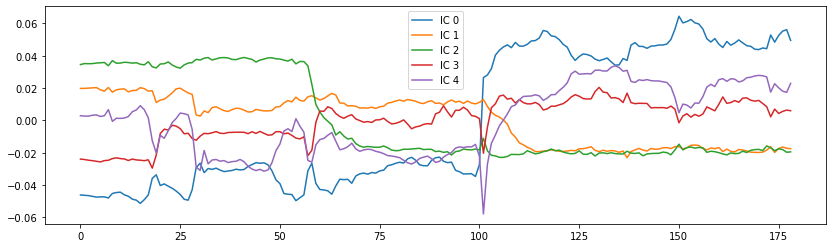

In [37]:
from scipy.stats.stats import pearsonr

# Get data of the functional image
orig_data = bold.get_fdata()

# Compute the pearson correlation between the components and the signal
curves = np.array([[pearsonr(components_img.get_fdata()[..., j].ravel(),
      orig_data[..., i].ravel())[0] for i in range(orig_data.shape[-1])]
        for j in range(canica.n_components)])

# Plot the components
fig = plt.figure(figsize=(14, 4))
centered_curves = curves - curves.mean(axis=1)[..., None]
plt.plot(centered_curves.T)
plt.legend(['IC %d' % i for i in range(canica.n_components)])

### Dictionary Learning

Recent work has shown that dictionary learning based techniques outperform ICA in term of stability and constitutes a better first step in a statistical analysis pipeline. Dictionary learning in neuro-imaging seeks to extract a few representative temporal elements along with their sparse spatial loadings, which constitute good extracted maps. Luckily, doing dictionary learning with `nilearn` is as easy as it can be.

DictLearning is a ready-to-use class with the same interface as CanICA. The sparsity of output map is controlled by a parameter alpha: using a larger alpha yields sparser maps.

In [38]:
# Import DictLearning module
from nilearn.decomposition import DictLearning

In [39]:
# Specify the dictionary learning object
dict_learning = DictLearning(n_components=n_components, n_epochs=1,
                             alpha=1., smoothing_fwhm=fwhm, standardize=True,
                             memory="nilearn_cache", memory_level=2,
                             verbose=1, random_state=0, n_jobs=-1)

In [40]:
# As before, let's fit the model to the data
dict_learning.fit(bold)

[MultiNiftiMasker.fit] Loading data from [Nifti1Image(
shape=(64, 64, 30, 179),
affine=array([[-3.99471426e+00, -2.04233140e-01,  2.29353290e-02,
         1.30641693e+02],
       [-2.05448717e-01,  3.98260689e+00, -3.10890853e-01,
        -9
[MultiNiftiMasker.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[DictLearning] Loading data
[DictLearning] Learning initial components
[DictLearning] Computing initial loadings
________________________________________________________________________________
[Memory] Calling nilearn.decomposition.dict_learning._compute_loadings...
_compute_loadings(array([[-0.00709 , ...,  0.019888],
       ...,
       [-0.012851, ...,  0.004881]], dtype=float32), 
array([[-3.780133, ...,  5.452174],
       ...,
       [ 0.66849 , ..., -8.287221]], dtype=float32))
_________________________________________________compute_loadings - 0.0s, 0.0min
[DictLearning] Learning dictionary
______________________________________________________________________

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


_____________________________________________dict_learning_online - 0.8s, 0.0min


DictLearning(alpha=1.0, batch_size=20, detrend=True, dict_init=None,
       high_pass=None, low_pass=None, mask=None, mask_args=None,
       mask_strategy='epi', memory=Memory(location=nilearn_cache/joblib),
       memory_level=2, method='cd', n_components=5, n_epochs=1, n_jobs=-1,
       random_state=0, reduction_ratio='auto', smoothing_fwhm=6.0,
       standardize=True, t_r=None, target_affine=None, target_shape=None,
       verbose=1)

In [41]:
# Retrieve the independent components in brain space
components_img = dict_learning.masker_.inverse_transform(dict_learning.components_)

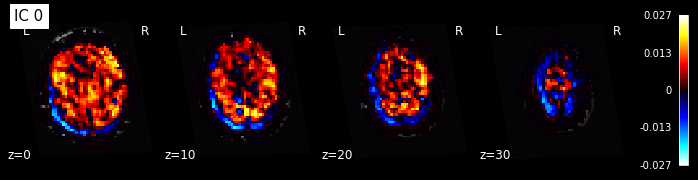

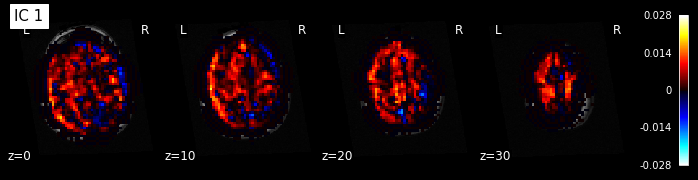

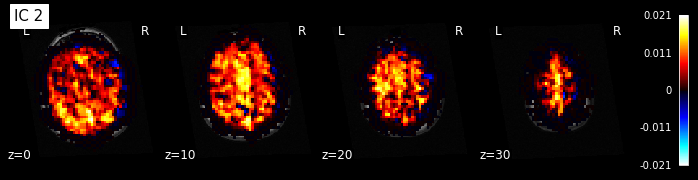

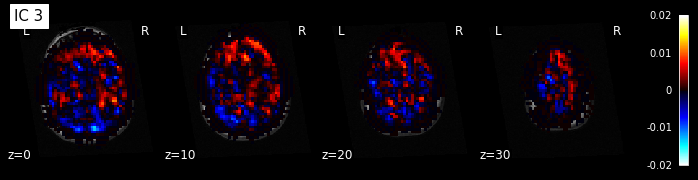

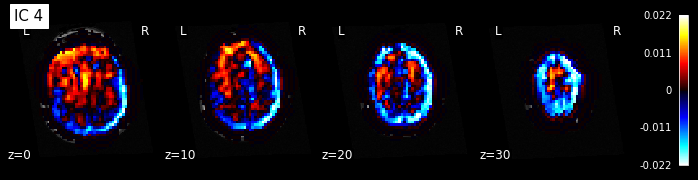

In [42]:
# Now let's plot the components
for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="z", title="IC %d" % i,
                  cut_coords=[0, 10, 20, 30], colorbar=True, bg_img=t1)

Maps obtained with dictionary leaning are often easier to exploit as they are less noisy than ICA maps, with blobs usually better defined. Typically, smoothing can be lower than when doing ICA. While dictionary learning computation time is comparable to CanICA, obtained atlases have been shown to outperform ICA in a variety of classification tasks.

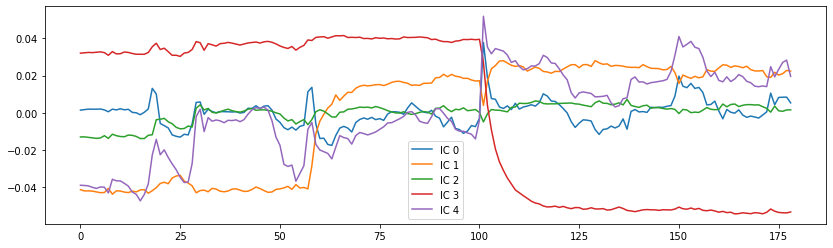

In [43]:
from scipy.stats.stats import pearsonr

# Get data of the functional image
orig_data = bold.get_fdata()

# Compute the pearson correlation between the components and the signal
curves = np.array([[pearsonr(components_img.get_fdata()[..., j].ravel(),
      orig_data[..., i].ravel())[0] for i in range(orig_data.shape[-1])]
        for j in range(dict_learning.n_components)])

# Plot the components
fig = plt.figure(figsize=(14, 4))
centered_curves = curves - curves.mean(axis=1)[..., None]
plt.plot(centered_curves.T)
plt.legend(['IC %d' % i for i in range(dict_learning.n_components)])

## 2. Image visualization with `nilearn`

Above, we've already seen some ways on how to visualize brain images with `nilearn`. And there are many more. To keep this notebook short, we will only take a look at some of them. For a complete list, see [nilearn's plotting section](http://nilearn.github.io/plotting/index.html).

**Note:** In most of the `nilearn`'s plotting functions, you can specify the value `'output_file=example.png'`, to save the figure directly to a file.

In [44]:
%matplotlib inline
from nilearn import plotting

Specify the functional file that we want to plot.

In [45]:
localizer_tmap = '/home/neuro/workshop/notebooks/data/brainomics_localizer/brainomics_data/'
localizer_tmap += 'S02/t_map_left_auditory_&_visual_click_vs_right_auditory&visual_click.nii.gz'

### Glass brain

A really cool way to visualize your brain images on the MNI brain is nilearn's `plot_glass_brain()` function. It gives you a good overview of all significant voxels in our image.

**Note**: It's important that your data is normalized to the MNI-template, as the overlay is otherwise not overlapping.

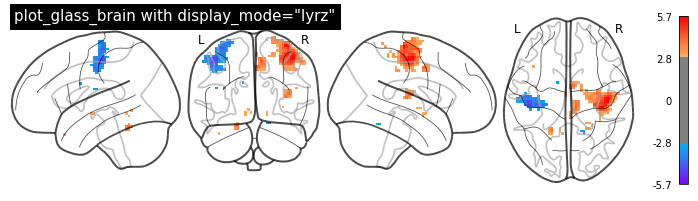

In [46]:
plotting.plot_glass_brain(localizer_tmap, threshold=3, colorbar=True,
                          title='plot_glass_brain with display_mode="lyrz"',
                          plot_abs=False, display_mode='lyrz', cmap='rainbow')

### Overlay functional image onto anatomical image

In this type of visualization, you can specify the axis through which you want to cut and the cut coordinates. `cut_coords` as integer 5 without a list implies that number of cuts in the slices should be maximum of 5.
The coordinates to cut the slices are selected automatically. But you could also specify the exact cuts with`cut_coords=[-10, 0, 10, 20]`.

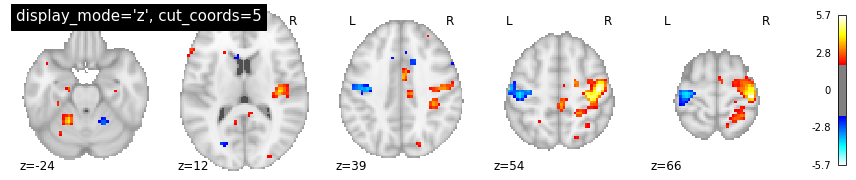

In [47]:
plotting.plot_stat_map(localizer_tmap, display_mode='z', cut_coords=5, threshold=2,
                       title="display_mode='z', cut_coords=5")

**Note**: `plot_stat_map()` can also be used to create figures with cuts in all directions, i.e. orthogonal cuts. For this, set `display_mode=ortho`:

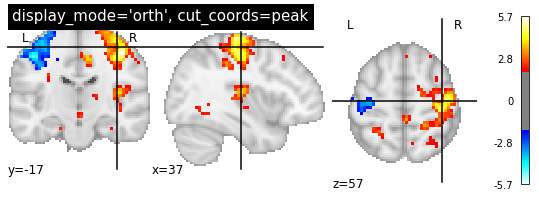

In [48]:
plotting.plot_stat_map(localizer_tmap, display_mode='ortho', threshold=2,
                       title="display_mode='orth', cut_coords=peak")

### Overlay two images ontop of each other

We can also create a plot that overlays different anatomical images. Let's show the `Harvard-Oxford-atlas` over the the `MNI 152 T1 template` image:


Dataset created in /home/neuro/nilearn_data/icbm152_2009



Downloaded 53854208 of 63027871 bytes (85.4%,    0.7s remaining) ...done. (6 seconds, 0 min)
Extracting data from /home/neuro/nilearn_data/icbm152_2009/774f5ced148e2fb443738680ac9b85a9/download..... done.


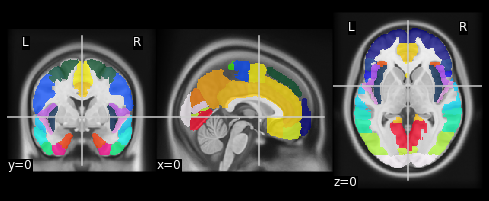

In [49]:
from nilearn.datasets import fetch_icbm152_2009
T1_tmp = fetch_icbm152_2009()
plotting.plot_roi('/usr/share/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-1mm.nii.gz',
                  T1_tmp['t1'], dim=0, cut_coords=(0, 0, 0))

Notice that nilearn will accept an image or a filename equally. Also recall that `t1` was a NIfTI-1 image, while `aseg` is in a FreeSurfer `.mgz` file. Nilearn takes advantage of the common interface (data-affine-header) that nibabel provides for these different formats, and makes correctly aligned overlays.

### Use `add_edges` to see the overlay between two images

Let's assume we want to see how well our anatomical image overlays with the mean functional image. Let's first load those two files:

In [50]:
import nilearn.image as nli
mean = nli.mean_img(bold)

Now, we can use the `plot_anat` plotting function to plot the background image, in this case the mean fMRI image. Followed by the `add_edges` function to overlay the edges of the anatomical image onto the mean image:

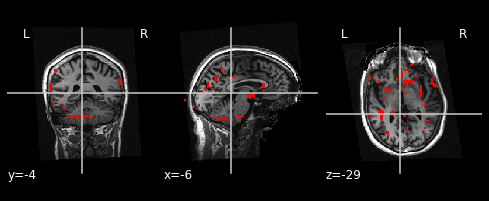

In [51]:
display = plotting.plot_anat(t1, dim=-1.0)
display.add_edges(mean, color='r')

### Exercise 1:

Using the function `plot_epi()`, draw the image `mean` as a set of 5 slices spanning front to back. Suppress the background using the `vmin` option.

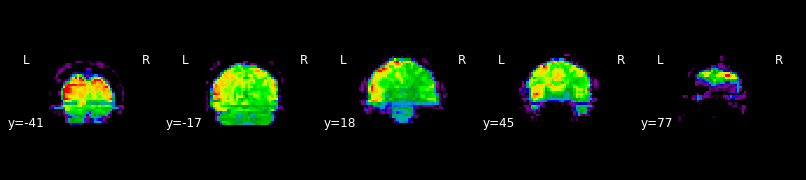

In [52]:
plotting.plot_epi(mean, display_mode='y', cut_coords=5, vmin=100)

In [53]:
# Create solution here

### Interactive visualizations

Nilearn also provides many methods for `interactive plotting`. For example, we can use `nilearn.plotting.view_img` to launch an `interactive viewer`. Because each `fMRI` run is a `4D time series` (three spatial dimensions plus time), we'll also need to subset the data when we plot it, so that we can look at a single `3D image`. `Nilearn` provides (at least) two ways to do this: with `nilearn.image.index_img`, which allows us to index a particular frame--or several frames--of a time series, and as done before `nilearn.image.mean_img`, which allows us to take the mean 3D image over 

Lets view the previously computed `mean image` interactively using:


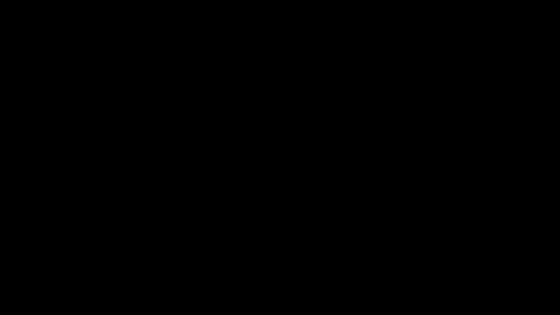
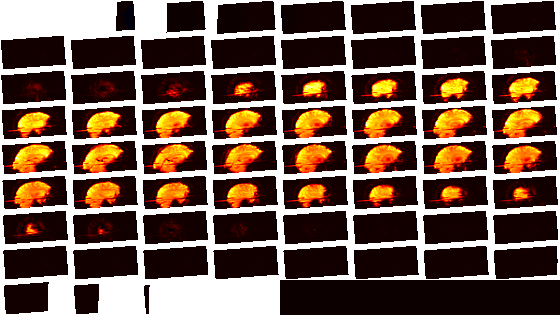

In [54]:
plotting.view_img(mean, threshold=None, bg_img=False)

### 3D Surface Plot

One of the newest features in nilearn is the possibility to project a 3D statistical map onto a cortical mesh using `nilearn.surface.vol_to_surf`. And then to display a surface plot of the projected map using `nilearn.plotting.plot_surf_stat_map`.

**Note:** Both of those modules require that your `matplotlib` version is 1.3.1 or higher and that your `nilearn` version is 0.4 or higher.

First, let's specify the location of the surface files:

In [55]:
fsaverage = {'pial_left': '/home/neuro/workshop/notebooks/data/fsaverage5/pial.left.gii',
             'pial_right': '/home/neuro/workshop/notebooks/data/fsaverage5/pial.right.gii',
             'infl_left': '/home/neuro/workshop/notebooks/data/fsaverage5/pial_inflated.left.gii',
             'infl_right': '/home/neuro/workshop/notebooks/data/fsaverage5/pial_inflated.right.gii',
             'sulc_left': '/home/neuro/workshop/notebooks/data/fsaverage5/sulc.left.gii',
             'sulc_right': '/home/neuro/workshop/notebooks/data/fsaverage5/sulc.right.gii'}

Project the statistical map from the volume onto the surface.

In [56]:
from nilearn import surface
texture = surface.vol_to_surf(localizer_tmap, fsaverage['pial_right'])

Now we are ready to plot the statistical map on the surface:

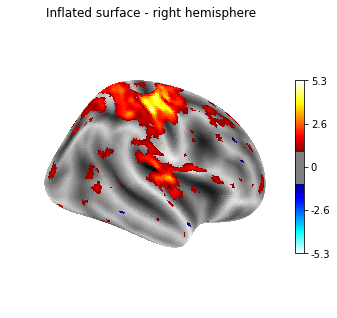

In [57]:
%matplotlib inline
from nilearn import plotting
plotting.plot_surf_stat_map(fsaverage['infl_right'], texture,
                            hemi='right', title='Inflated surface - right hemisphere',
                            threshold=1., bg_map=fsaverage['sulc_right'],
                            view='lateral', cmap='cold_hot')
plotting.show()

Or another example, using the pial surface:

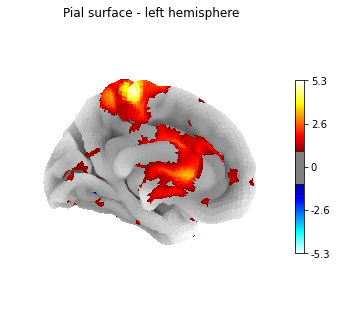

In [58]:
plotting.plot_surf_stat_map(fsaverage['pial_left'], texture,
                            hemi='left',  title='Pial surface - left hemisphere',
                            threshold=1., bg_map=fsaverage['sulc_left'],
                            view='medial', cmap='cold_hot')
plotting.show()

From version `0.5.0` on, `nilearn` provides interactive visual views also for surface plots. The great thing is that you actually don't need to project your statistical maps onto the surface, `nilearn` does that directly for you.

So taking the `localizer_tmap` from before we can call the interactive plotting function `view_img_on_surf`

In [59]:
plotting.view_img_on_surf(localizer_tmap, surf_mesh='fsaverage5',
                          threshold=0, cmap='cold_hot', vmax=3)